In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from PIL import Image
from helper import *

In [12]:
def get_second_largest_indices(arr):
    indices = []
    for vec in arr:
        largest_idx = np.argmax(np.abs(vec))
        abs_vec = np.abs(vec).copy()
        abs_vec[largest_idx] = -np.inf
        second_idx = np.argmax(abs_vec)
        indices.append(second_idx)
    return np.array(indices)

def plot_histogram(bg_hist, fg_hist):

    # Add small epsilon to avoid zero probabilities
    epsilon = 1e-10
    bg_hist = bg_hist + epsilon
    fg_hist = fg_hist + epsilon

    # Re-normalize after adding epsilon
    bg_hist = bg_hist / np.sum(bg_hist)
    fg_hist = fg_hist / np.sum(fg_hist)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(bg_indices, bins=bins, density=True, label='P(X=k | Y=BG)', alpha=0.7, rwidth=0.9)
    axes[0].set_xlabel('Index (k)')
    axes[0].set_ylabel('Probability')
    axes[0].legend()
    axes[0].set_title('Histogram of 2nd Largest DCT Coeff. Index (BG)')

    axes[1].hist(fg_indices, bins=bins, density=True, label='P(X=k | Y=FG)', alpha=0.7, rwidth=0.9)
    axes[1].set_xlabel('Index (k)')
    axes[1].set_ylabel('Probability')
    axes[1].legend()
    axes[1].set_title('Histogram of 2nd Largest DCT Coeff. Index (FG)')

    plt.tight_layout()
    plt.show()
    fig.savefig('results/histogram.png')

def create_zigzag_pattern():
    """Create zig-zag pattern for 8x8 DCT blocks"""
    pattern = [
        [0, 1, 5, 6, 14, 15, 27, 28],
        [2, 4, 7, 13, 16, 26, 29, 42],
        [3, 8, 12, 17, 25, 30, 41, 43],
        [9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]
    ]
    return np.array(pattern)

def dct2d_block(block):
    """Compute 2D DCT for an 8x8 block"""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def extract_feature_from_block(block, zigzag_pattern):

    dct_coeffs = dct2d_block(block)

    zigzag_vector = np.zeros(64)
    for i in range(8):
        for j in range(8):
            zigzag_idx = zigzag_pattern[i, j]
            zigzag_vector[zigzag_idx] = dct_coeffs[i, j]

    abs_coeffs = np.abs(zigzag_vector)
    largest_idx = np.argmax(abs_coeffs)
    abs_coeffs_copy = abs_coeffs.copy()
    abs_coeffs_copy[largest_idx] = -np.inf
    second_largest_idx = np.argmax(abs_coeffs_copy)

    return second_largest_idx

def classify_image_bayesian(image, fg_hist, bg_hist, P_FG, P_BG, zigzag_pattern):

    height, width = image.shape
    predicted_mask = np.zeros((height, width))

    # Sliding window: move pixel by pixel for smoother results
    for i in range(height - 7):

        for j in range(width - 7):
            # Extract 8x8 block
            block = image[i:i+8, j:j+8]

            # Extract feature (index of 2nd largest coefficient)
            k = extract_feature_from_block(block, zigzag_pattern)

            # Look up class-conditional probabilities from histograms
            likelihood_fg = fg_hist[k]
            likelihood_bg = bg_hist[k]

            # Apply Bayes rule to compute posteriors
            posterior_fg = likelihood_fg * P_FG
            posterior_bg = likelihood_bg * P_BG

            # Normalize
            total = posterior_fg + posterior_bg
            if total > 0:
                posterior_fg /= total
                posterior_bg /= total

            # Decision rule: classify as FG if P(FG|X) > P(BG|X)
            # Assign to center pixel of the block (or top-left corner)
            predicted_mask[i+4, j+4] = 1 if posterior_fg > posterior_bg else 0

    print("Classification complete!")
    return predicted_mask

In [13]:
mat_contents = sio.loadmat('input\TrainingSamplesDCT_8.mat')

In [14]:
bg = mat_contents['TrainsampleDCT_BG']
fg = mat_contents['TrainsampleDCT_FG']

n_bg = bg.shape[0]
n_fg = fg.shape[0]

P_FG = n_fg / (n_fg + n_bg)
P_BG = n_bg / (n_fg + n_bg)

print(f"P(Y=fg): {P_FG}")
print(f"P(Y=bg): {P_BG}")

P(Y=fg): 0.1918649270913277
P(Y=bg): 0.8081350729086723


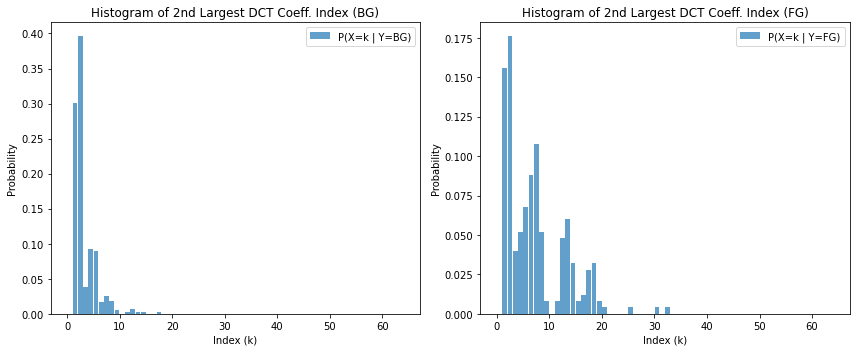

In [15]:
bg_indices = get_second_largest_indices(bg)
fg_indices = get_second_largest_indices(fg)

bg_hist, bins = np.histogram(bg_indices, bins=np.arange(65), density=True)
fg_hist, _ = np.histogram(fg_indices, bins=np.arange(65), density=True)

plot_histogram(bg_indices,fg_indices)

In [16]:
cheetah_img = np.array(Image.open('input/cheetah.bmp').convert('L'))
cheetah_img = cheetah_img.astype(np.float64) / 255.0  # Convert to doubles in [0, 1]

zigzag_pattern = create_zigzag_pattern()

In [17]:
predicted_mask = classify_image_bayesian(cheetah_img, fg_hist, bg_hist, P_FG, P_BG, zigzag_pattern)

Classification complete!


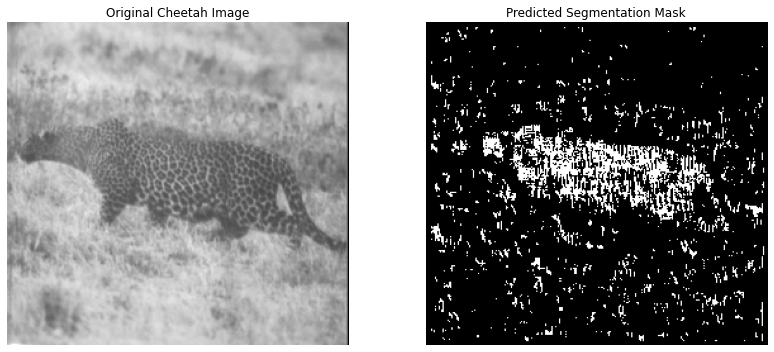

In [ ]:
# comaparison of original and predicted segmentation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cheetah_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

result_img = Image.fromarray((predicted_mask * 255).astype(np.uint8))
result_img.save('results/cheetah_predicted_mask.bmp')

In [22]:
ground_truth = np.array(Image.open('input/cheetah_mask.bmp').convert('L')) / 255.0

min_h = min(predicted_mask.shape[0], ground_truth.shape[0])
min_w = min(predicted_mask.shape[1], ground_truth.shape[1])

pred_crop = predicted_mask[:min_h, :min_w]
truth_crop = ground_truth[:min_h, :min_w]

pred_binary = (pred_crop > 0.5).astype(int)
truth_binary = (truth_crop > 0.5).astype(int)


In [23]:
errors = np.sum(pred_binary != truth_binary)
total_pixels = pred_binary.size
error_probability = errors / total_pixels

print(f"Probability of Error: {error_probability:.6f}")
print(f"Accuracy: {(1 - error_probability) * 100:.2f}%")

Probability of Error: 0.171503
Accuracy: 82.85%


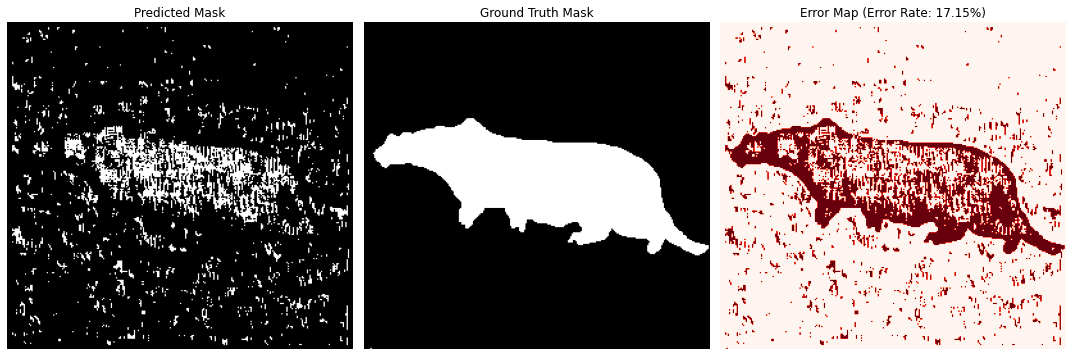

In [ ]:
# Comparison of predicted, ground truth and error map
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(pred_binary, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(truth_binary, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
error_map = np.abs(pred_binary - truth_binary)
plt.imshow(error_map, cmap='Reds')
plt.title(f'Error Map (Error Rate: {error_probability:.2%})')
plt.axis('off')
plt.tight_layout()
plt.show()